In [1]:
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms import QAOA
from qiskit.primitives import Sampler
from qiskit_algorithms.optimizers import COBYLA
from qiskit_optimization import QuadraticProgram

In [2]:
def optimize_battery_revenue(lambda1, lambda2, lambda3, c1, c2, c3, c_max):
    """
    Classical optimization with strict C_max constraint
    """
    n = len(lambda1)
    values = [lambda1, lambda2, lambda3]
    costs = [c1, c2, c3]
    
    def backtrack(index, current_cost, current_revenue, current_solution):
        if index == n:
            return current_solution, current_revenue
        
        best_solution, best_revenue = None, -float('inf')
        
        for market in range(3):
            new_cost = current_cost + costs[market][index]
            new_revenue = current_revenue + values[market][index]
            
            if new_cost <= c_max:
                solution, revenue = backtrack(
                    index + 1, 
                    new_cost, 
                    new_revenue, 
                    current_solution + [market]
                )
                
                if solution and revenue > best_revenue:
                    best_solution, best_revenue = solution, revenue
        
        return best_solution, best_revenue

    solution, revenue = backtrack(0, 0, 0, [])
    return solution, revenue


In [3]:
def formulate_qp(L1, L2, L3, C1, C2, C3, C_max):
    """
    Formulate the knapsack problem as a quadratic program using Qiskit's QuadraticProgram.

    Args:
        L1, L2, L3: Profit values for three states.
        C1, C2, C3: Cost values for three states.
        C_max: Maximum allowable cost.

    Returns:
        QuadraticProgram: The formulated quadratic program.
    """
    n = len(L1)
    mod = QuadraticProgram("QAOA Knapsack Problem")

    # Define binary variables for each item
    for i in range(n):
        mod.binary_var(name=f"L1_{i}")
        mod.binary_var(name=f"L2_{i}")
        mod.binary_var(name=f"L3_{i}")

    # Objective function: maximize profits
    linear_terms = {}
    for i in range(n):
        # Linear terms for each variable
        linear_terms[f"L1_{i}"] = L1[i] 
        linear_terms[f"L2_{i}"] = L2[i]
        linear_terms[f"L3_{i}"] = L3[i]

    # Add linear terms to the objective
    mod.maximize(linear=linear_terms)

    # Constraint: Each item must be in exactly one state
    for i in range(n):
        mod.linear_constraint(
            linear={f"L1_{i}": 1, f"L2_{i}": 1, f"L3_{i}": 1},
            sense="==",
            rhs=1,
            name=f"state_constraint_{i}",
        )

    # Constraint: Cost must not exceed C_max
    cost_linear_terms = {}
    for i in range(n):
        cost_linear_terms[f"L1_{i}"] = C1[i]
        cost_linear_terms[f"L2_{i}"] = C2[i]
        cost_linear_terms[f"L3_{i}"] = C3[i]

    # Add the cost constraint
    mod.linear_constraint(
        linear=cost_linear_terms,
        sense="<=",
        rhs=C_max,
        name="cost_constraint",
    )

    return mod

In [4]:
def solve_qp_with_qiskit(L1, L2, L3, C1, C2, C3, C_max):
    """
    Solve the quadratic program using Qiskit's optimization solvers.

    Args:
        L1, L2, L3, C1, C2, C3, C_max: Problem parameters.

    Returns:
        dict: Solution details including selected items and total revenue.
    """
    qp = formulate_qp(L1, L2, L3, C1, C2, C3, C_max)

    # Print the formulated QP
    print(qp.prettyprint())


    qaoa = QAOA(sampler=Sampler(), optimizer=COBYLA())
    
    optimizer = MinimumEigenOptimizer(qaoa)

    result = optimizer.solve(qp)
    solution = result.x
    
    # Extract results
    total_profit = 0
    assignments = []
    for i in range(len(L1)):
        if solution[3 * i] == 1:
            total_profit += L1[i]
            assignments.append(f"L1_{i}")
        elif solution[3 * i + 1] == 1:
            total_profit += L2[i]
            assignments.append(f"L2_{i}")
        elif solution[3 * i + 2] == 1:
            total_profit += L3[i]
            assignments.append(f"L3_{i}")

    return {
        "solution": solution,
        "assignments": assignments,
        "total_profit": total_profit,
        "ansatz": qaoa.ansatz
    }

In [5]:
# L1 = [3, 5, 2, 4]
# L2 = [7, 1, 6, 8]
# L3 = [8, 2, 4, 5]
# C1 = [2, 3, 5, 4]
# C2 = [4, 2, 1, 5]
# C3 = [3, 4, 2, 6]


L1 = [3, 5, 2, ]
L2 = [7, 1, 6, ]
L3 = [8, 2, 4, ]
C1 = [2, 3, 5, ]
C2 = [4, 2, 1, ]
C3 = [3, 4, 2, ]
C_max = 10

print("optimize_battery_revenue")
solution, revenue = optimize_battery_revenue(L1, L2, L3, C1, C2, C3, C_max)
print("Market Selection:", solution)
print("Total Revenue:", revenue)

print("\n---\nsolve_qp_with_qiskit")
result = solve_qp_with_qiskit(L1, L2, L3, C1, C2, C3, C_max)
print("Solution:", result["solution"])
print("Assignments:", result["assignments"])
print("Total Profit:", result["total_profit"])

optimize_battery_revenue
Market Selection: [2, 0, 1]
Total Revenue: 19

---
solve_qp_with_qiskit
Problem name: QAOA Knapsack Problem

Maximize
  3*L1_0 + 5*L1_1 + 2*L1_2 + 7*L2_0 + L2_1 + 6*L2_2 + 8*L3_0 + 2*L3_1 + 4*L3_2

Subject to
  Linear constraints (4)
    L1_0 + L2_0 + L3_0 == 1  'state_constraint_0'
    L1_1 + L2_1 + L3_1 == 1  'state_constraint_1'
    L1_2 + L2_2 + L3_2 == 1  'state_constraint_2'
    2*L1_0 + 3*L1_1 + 5*L1_2 + 4*L2_0 + 2*L2_1 + L2_2 + 3*L3_0 + 4*L3_1 + 2*L3_2
    <= 10  'cost_constraint'

  Binary variables (9)
    L1_0 L2_0 L3_0 L1_1 L2_1 L3_1 L1_2 L2_2 L3_2



C:\Users\forca\AppData\Local\Temp\ipykernel_12104\509891218.py:17: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  qaoa = QAOA(sampler=Sampler(), optimizer=COBYLA())


Solution: [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Assignments: ['L3_0', 'L1_1', 'L2_2']
Total Profit: 19


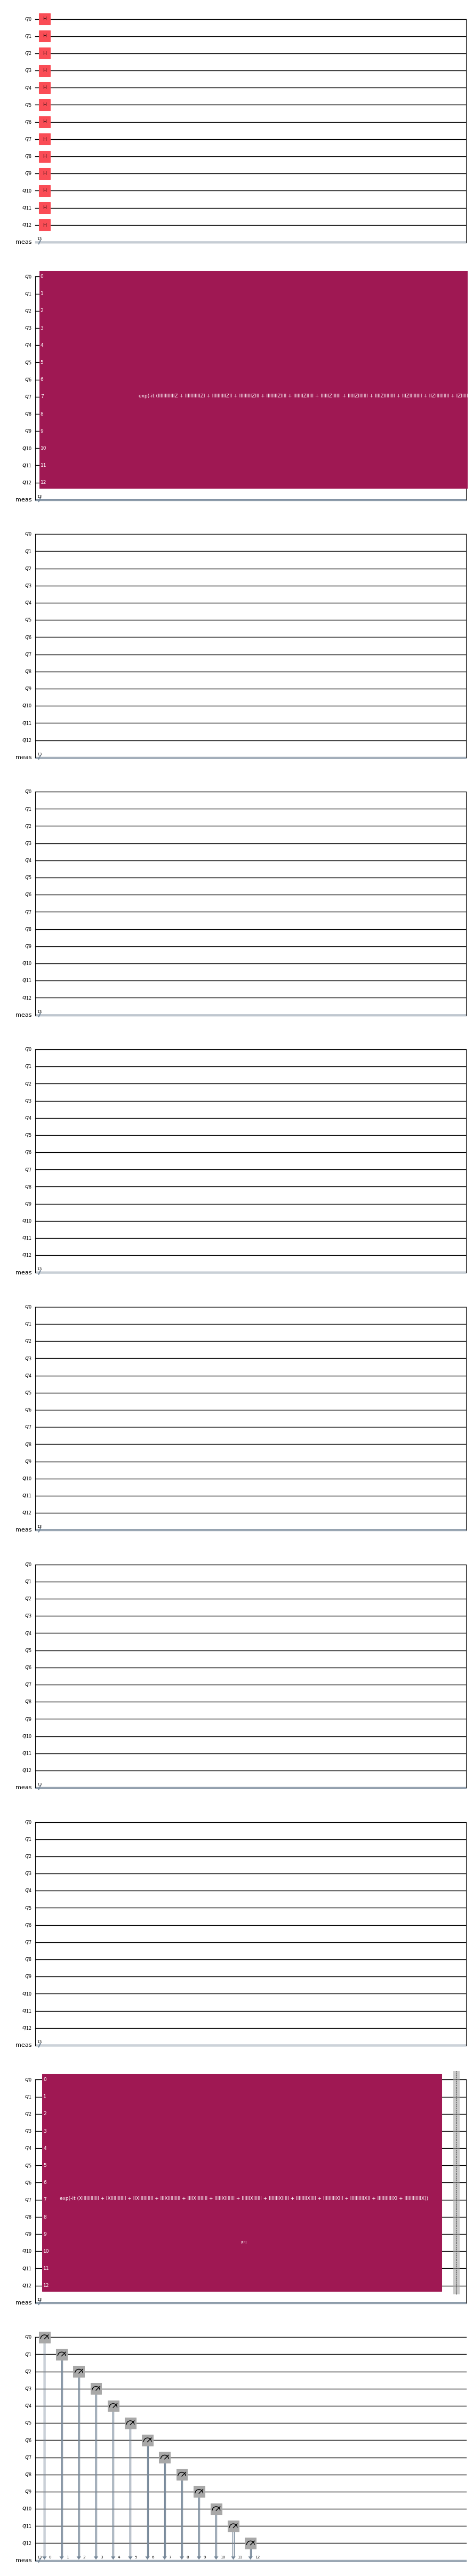

In [11]:
result["ansatz"].draw(output='mpl', scale=0.5)